In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
from scipy import stats
from stargazer.stargazer import Stargazer
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sympy import preview

In [2]:
# first elem is top, last elem is bottom

default_mask = [
    'ah', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', 'th', 'jh', 'qh', 'kh',
    'ac', '2c', '3c', '4c', '5c', '6c', '7c', '8c', '9c', 'tc', 'jc', 'qc', 'kc',
    'ad', '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', 'td', 'jd', 'qd', 'kd',
    'as', '2s', '3s', '4s', '5s', '6s', '7s', '8s', '9s', 'ts', 'js', 'qs', 'ks'
]

In [3]:
# Function to convert title into a valid Python variable name
def format_title(title):
    return title.strip().lower().replace(".", "_").replace(" ", "_")

def memoize(func):
    cache = {}
    def memoized_func(*args, **kwargs):
        args_key = tuple(tuple(arg) if isinstance(arg, list) else arg for arg in args) #tuples so hashable
        kwargs_key = tuple(sorted((key, tuple(value) if isinstance(value, list) else value) for key, value in kwargs.items()))
        key = (args_key, kwargs_key) 
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]
    return memoized_func

@memoize
def masked_order_dict(mask: list) -> dict:
    mask_dict = {}
    for index, value in enumerate(mask):
        mask_dict[value] = index
    return mask_dict

def masked_order(deck:list, mask:list=default_mask) -> list:
    assert all([card in default_mask for card in deck]), "Non-card found"
    assert set(deck) == set(default_mask), "Missing card"
    assert len(deck) == 52, "Duplicate card"
    mask_dict = masked_order_dict(mask)
    masked_deck = []
    for value in deck:
        masked_deck.append(mask_dict[value])
    return masked_deck

def script(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    current_title = ""
    shuffles = {}
    titles = []

    # Iterate over each line in the file
    for line in lines:
        if line.strip().endswith(':'):
            # This is a title line
            current_title = format_title(line.strip()[:-1])
        elif line.strip() and current_title:
            # This is an item line corresponding to the current title
            items_list = [item.replace(" ", "").strip().lower() for item in line.split(',')]
            shuffles[current_title] = items_list
            titles.append(current_title)
            current_title = ""  # Reset current title for the next section

    prettified_dict = {}
    bad_indexes = []
    index = 0
    for list_name, items_list in shuffles.items():
        if items_list != ["throwout"]:
            prettified_dict[index] = items_list
        else:
            bad_indexes.append(index)
        index += 1

    prettified_dict[19];

    ## DATA VALIDATION

    for key, value in prettified_dict.items():
        doubled = list(set([x for x in value if value.count(x) >= 2]))
        not_found = [card for card in default_mask if card not in set(value)]
        if not all([card in default_mask for card in value]):
            print(f"Non-card found in ID: {titles[key]}: {[card for card in value if card not in default_mask]}")
        if not set(value) == set(default_mask):
            doubled = list(set([x for x in value if value.count(x) >= 2]))
            print(f"Missing card in ID: {titles[key]}, {not_found}; Double card: {doubled}")
        # assert len(value) == 52, "uhh"
    return prettified_dict, bad_indexes

# script("digitized_shuffles.txt")
default_order = masked_order(default_mask)

yoeri_dict, yoeri_bad = script("Data/Yoeri/yoeri_digitized.txt")
yoeri_ranges = (range(0, yoeri_bad[0]), range(yoeri_bad[0]+1, 141), range(141,162), range(162,192))

jeffq_dict, _ = script("Data/Jeff Q/Jeff Q Shuffles.txt")
jeffq_ranges = (range(len(jeffq_dict.keys())), ...)

jeffs_dict, _ = script("Data/Jeff S/jeff_s_riffles.txt")
jeffs_ranges = (range(50), ...)


Missing card in ID: 9_10_47, ['th', 'jc']; Double card: ['7c', 'kh']
Missing card in ID: 9_13_59, ['jh', '8c', '7d']; Double card: []
Missing card in ID: 9_14_17, ['6c']; Double card: ['tc']
Missing card in ID: 9_17_42, ['qd']; Double card: []
Missing card in ID: 9_18_09, ['3c']; Double card: ['3s']
Missing card in ID: 9_18_55, ['th', 'qh']; Double card: []
Missing card in ID: 9_21_49, ['7c', '6d', '5s']; Double card: ['9d', '3c', '5c']
Missing card in ID: 9_22_09, ['jh']; Double card: []
Missing card in ID: 9_22_29, ['6c', '3s']; Double card: ['6d', '9s']
Missing card in ID: 9_24_48, ['ah']; Double card: []
Missing card in ID: 9_28_26, ['8c', '6d']; Double card: ['ac', '6c']
Missing card in ID: 9_29_03, ['8c']; Double card: ['ac']
Missing card in ID: 9_29_29, ['8c']; Double card: ['ac']
Missing card in ID: 9_30_55, ['qd']; Double card: []
Missing card in ID: 9_31_16, ['jh', '8c']; Double card: ['ac']
Missing card in ID: 9_31_37, ['jh']; Double card: []
Missing card in ID: 9_39_03, ['a

In [4]:
fifty_two_card_probs = [scipy.special.comb(52, k) / (2**52) for k in range(0, 52 + 1)]

def binomial_random_number(n:int) -> int:
    # outputs a random number from [0, n] according to the binomial distribution
    # probabilities = [scipy.special.comb(n, k) / (2**n) for k in range(0, n + 1)]  #TODO: if computation slow, memoize probablities
    probabilities = fifty_two_card_probs
    assert sum(probabilities) == 1
    random_number = np.random.choice(range(0, n + 1), p=probabilities)
    return random_number

def GSR_shuffle(deck:list):
    #presume left pile is bottom (cut # cards) and right half is top (cut # cards are cut off)
    cut = binomial_random_number(52)
    right_deck = deck[:52-cut] #cut off binom cards
    left_deck = deck[52-cut:]
    assert len(left_deck) == cut, "left pile is not cut # cards"
    shuffled_deck = []
    while(left_deck or right_deck):
        num_cards_left = len(left_deck)
        num_cards_right = len(right_deck)
        p_left = num_cards_left / (num_cards_left + num_cards_right)
        select_left = np.random.choice(2, p=[1-p_left, p_left])
        if select_left:
            shuffled_deck.insert(0, left_deck.pop())
        else:
            shuffled_deck.insert(0, right_deck.pop())
    assert len(shuffled_deck) == 52, "uhhh"
    return shuffled_deck

GSR_shuffle(default_order);

def l2_loss_func(y, y_hat):
    loss = 0
    for index, value in enumerate(y):
        loss += (value - y_hat[index])**2
    return loss

def kldiv_loss_func(y, y_hat):
    loss = 0
    y = [x+1 for x in y] #to stop divide by zero, offset by 1
    y_hat = [x+1 for x in y_hat]
    for index, value in enumerate(y):
        loss += scipy.special.kl_div(value, y_hat[index])
    return loss

def spearman_rank_corr(y, y_hat):
    return scipy.stats.spearmanr(y, y_hat).statistic

def kendalls_tau(y, y_hat):
    return scipy.stats.kendalltau(y, y_hat).statistic

In [5]:
## FOR YOERI GRAPHS

assert all(default_order == np.arange(52))
def risk(loss_func):
    G = []
    for _ in tqdm(range(10_000)):
        G.append(loss_func(default_order, GSR_shuffle(default_order)))

    U = []
    for _ in tqdm(range(10_000)):
        U.append(loss_func(default_order, random.sample(range(0, 52), 52)))

    E = []
    # for i in tqdm(range(19)):
    for curr, next in zip(yoeri_ranges[0], yoeri_ranges[0][1:]):
        assert default_order == masked_order(yoeri_dict[curr], mask=yoeri_dict[curr])
        E.append(loss_func(masked_order(yoeri_dict[curr], mask=yoeri_dict[curr]), masked_order(yoeri_dict[next], mask=yoeri_dict[curr])))
    for curr, next in zip(yoeri_ranges[1], yoeri_ranges[1][1:]):
        assert default_order == masked_order(yoeri_dict[curr], mask=yoeri_dict[curr])
        E.append(loss_func(masked_order(yoeri_dict[curr], mask=yoeri_dict[curr]), masked_order(yoeri_dict[next], mask=yoeri_dict[curr])))
    
    return G, U, E

dealer_num = 1

In [6]:
# ## FOR JEFF Q GRAPHS

# assert all(default_order == np.arange(52))
# def risk(loss_func):
#     G = []
#     for _ in tqdm(range(10_000)):
#         G.append(loss_func(default_order, GSR_shuffle(default_order)))

#     U = []
#     for _ in tqdm(range(10_000)):
#         U.append(loss_func(default_order, random.sample(range(0, 52), 52)))

#     E = []
#     for curr, next in zip(jeffq_ranges[0], jeffq_ranges[0][1:]):
#         assert default_order == masked_order(jeffq_dict[curr], mask=jeffq_dict[curr])
#         E.append(loss_func(masked_order(jeffq_dict[curr], mask=jeffq_dict[curr]), masked_order(jeffq_dict[next], mask=jeffq_dict[curr])))
    
#     return G, U, E

# dealer_num = 2

In [7]:
# ## FOR JEFF S GRAPHS

# assert all(default_order == np.arange(52))
# def risk(loss_func):
#     G = []
#     for _ in tqdm(range(10_000)):
#         G.append(loss_func(default_order, GSR_shuffle(default_order)))

#     U = []
#     for _ in tqdm(range(10_000)):
#         U.append(loss_func(default_order, random.sample(range(0, 52), 52)))

#     E = []
#     for curr, next in zip(jeffs_ranges[0], jeffs_ranges[0][1:]):
#         assert default_order == masked_order(jeffs_dict[curr], mask=jeffs_dict[curr])
#         E.append(loss_func(masked_order(jeffs_dict[curr], mask=jeffs_dict[curr]), masked_order(jeffs_dict[next], mask=jeffs_dict[curr])))
    
#     return G, U, E

# dealer_num = 3

100%|██████████| 10000/10000 [00:01<00:00, 7842.09it/s]


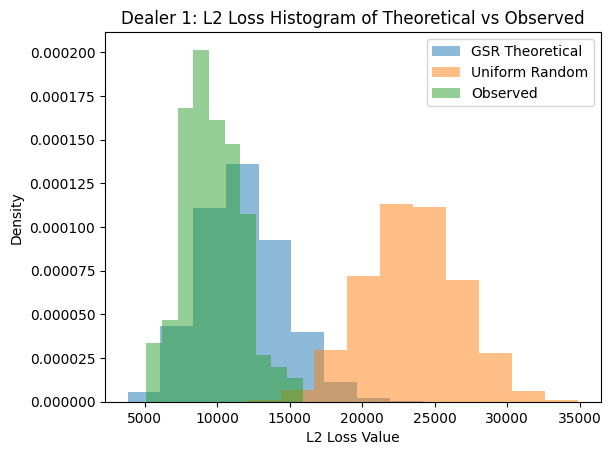

In [8]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(l2_loss_func)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Observed", alpha=0.5)
plt.xlabel('L2 Loss Value')
plt.ylabel('Density')
plt.title(f'Dealer {dealer_num}: L2 Loss Histogram of Theoretical vs Observed')
plt.legend(loc='best')
plt.savefig(f'Figures/Dealer{dealer_num}_L2_Hist.png')
plt.show()

In [9]:
min_length = min(len(GSR_single_shuffle_simulated_loss), len(uniform_random_single_shuffle_simulated_loss), len(empirical_single_shuffle_simulated_loss))

np.random.seed(42)  # For reproducibility
GSR_resampled = np.random.choice(GSR_single_shuffle_simulated_loss, min_length, replace=False)
uniform_random_resampled = np.random.choice(uniform_random_single_shuffle_simulated_loss, min_length, replace=False)
empirical_resampled = np.random.choice(empirical_single_shuffle_simulated_loss, min_length, replace=False)

data_anova = {
    'GSR': GSR_resampled,
    'Observed': empirical_resampled
}
df_anova = pd.DataFrame(data_anova)
df_anova_long = pd.melt(df_anova, var_name='Group', value_name='Loss')

anova_model_gsr_empirical = ols('Loss ~ C(Group)', data=df_anova_long).fit()
anova_table_gsr_empirical = sm.stats.anova_lm(anova_model_gsr_empirical, typ=2)

stargazer_gsr_empirical = Stargazer([anova_model_gsr_empirical])
stargazer_gsr_empirical.custom_columns([f"Dealer {dealer_num}: L2 ANOVA"], [1])
stargazer_gsr_empirical.show_model_numbers(False)
latex_str = stargazer_gsr_empirical.render_latex()

def latex2png(latex, filename, fontsize=500):
    """
    Render latex code to png image
    """
    return preview(latex,
                   viewer='file',
                   filename=filename,
                   euler=False,
                   dvioptions=['-D', f'{str(fontsize)}'])

latex2png(latex_str, f'Figures/Dealer{dealer_num}_L2_Anova.png')

In [10]:
# plt.hist(GSR_resampled, density=True, label="GSR Theoretical", alpha=0.5)
# plt.hist(uniform_random_resampled, density=True, label="Uniform Random", alpha=0.5)
# plt.hist(empirical_resampled, density=True, label="Empirical", alpha=0.5)
# plt.xlabel('L2 Loss Value')
# plt.ylabel('Density')
# plt.title('L2 Loss Histogram of Theoretical vs Empirical')
# plt.legend(loc='best')
# plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4793.54it/s]


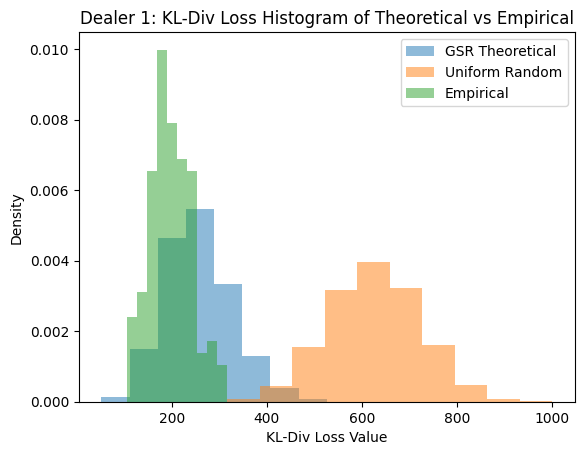

In [11]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(kldiv_loss_func)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel('KL-Div Loss Value')
plt.ylabel('Density')
plt.title(f'Dealer {dealer_num}: KL-Div Loss Histogram of Theoretical vs Empirical')
plt.legend(loc='best')
plt.savefig(f'Figures/Dealer{dealer_num}_KLDiv_Hist.png')
plt.show()

In [12]:
min_length = min(len(GSR_single_shuffle_simulated_loss), len(uniform_random_single_shuffle_simulated_loss), len(empirical_single_shuffle_simulated_loss))

np.random.seed(42)  # For reproducibility
GSR_resampled = np.random.choice(GSR_single_shuffle_simulated_loss, min_length, replace=False)
uniform_random_resampled = np.random.choice(uniform_random_single_shuffle_simulated_loss, min_length, replace=False)
empirical_resampled = np.random.choice(empirical_single_shuffle_simulated_loss, min_length, replace=False)

data_anova = {
    'GSR': GSR_resampled,
    'Observed': empirical_resampled
}
df_anova = pd.DataFrame(data_anova)
df_anova_long = pd.melt(df_anova, var_name='Group', value_name='Loss')

anova_model_gsr_empirical = ols('Loss ~ C(Group)', data=df_anova_long).fit()
anova_table_gsr_empirical = sm.stats.anova_lm(anova_model_gsr_empirical, typ=2)

stargazer_gsr_empirical = Stargazer([anova_model_gsr_empirical])
stargazer_gsr_empirical.custom_columns([f"Dealer {dealer_num}: KL-Div ANOVA"], [1])
stargazer_gsr_empirical.show_model_numbers(False)
latex_str = stargazer_gsr_empirical.render_latex()

def latex2png(latex, filename, fontsize=500):
    """
    Render latex code to png image
    """
    return preview(latex,
                   viewer='file',
                   filename=filename,
                   euler=False,
                   dvioptions=['-D', f'{str(fontsize)}'])

latex2png(latex_str, f'Figures/Dealer{dealer_num}_KLDiv_Anova.png')

100%|██████████| 10000/10000 [00:08<00:00, 1249.79it/s]


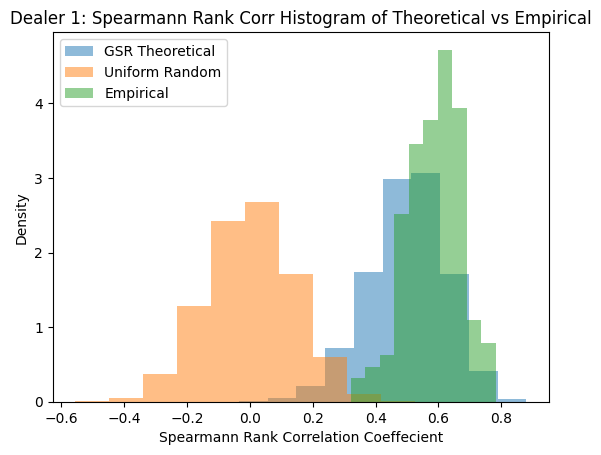

In [13]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(spearman_rank_corr)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel('Spearmann Rank Correlation Coeffecient')
plt.ylabel('Density')
plt.title(f'Dealer {dealer_num}: Spearmann Rank Corr Histogram of Theoretical vs Empirical')
plt.legend(loc='best')
plt.savefig(f'Figures/Dealer{dealer_num}_Spearmann_Hist.png')
plt.show()

In [14]:
min_length = min(len(GSR_single_shuffle_simulated_loss), len(uniform_random_single_shuffle_simulated_loss), len(empirical_single_shuffle_simulated_loss))

np.random.seed(42)  # For reproducibility
GSR_resampled = np.random.choice(GSR_single_shuffle_simulated_loss, min_length, replace=False)
uniform_random_resampled = np.random.choice(uniform_random_single_shuffle_simulated_loss, min_length, replace=False)
empirical_resampled = np.random.choice(empirical_single_shuffle_simulated_loss, min_length, replace=False)

data_anova = {
    'GSR': GSR_resampled,
    'Observed': empirical_resampled
}
df_anova = pd.DataFrame(data_anova)
df_anova_long = pd.melt(df_anova, var_name='Group', value_name='Loss')

anova_model_gsr_empirical = ols('Loss ~ C(Group)', data=df_anova_long).fit()
anova_table_gsr_empirical = sm.stats.anova_lm(anova_model_gsr_empirical, typ=2)

stargazer_gsr_empirical = Stargazer([anova_model_gsr_empirical])
stargazer_gsr_empirical.custom_columns([f"Dealer {dealer_num}: Spearmann Rank Correlation ANOVA"], [1])
stargazer_gsr_empirical.show_model_numbers(False)
latex_str = stargazer_gsr_empirical.render_latex()

def latex2png(latex, filename, fontsize=500):
    """
    Render latex code to png image
    """
    return preview(latex,
                   viewer='file',
                   filename=filename,
                   euler=False,
                   dvioptions=['-D', f'{str(fontsize)}'])

latex2png(latex_str, f'Figures/Dealer{dealer_num}_Spearmann_Anova.png')

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1865.96it/s]


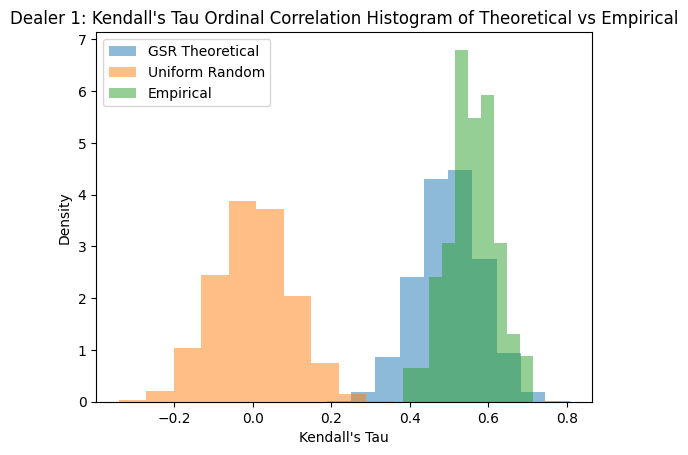

In [15]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(kendalls_tau)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel("Kendall's Tau")
plt.ylabel('Density')
plt.title(f"Dealer {dealer_num}: Kendall's Tau Ordinal Correlation Histogram of Theoretical vs Empirical")
plt.legend(loc='best')
plt.savefig(f'Figures/Dealer{dealer_num}_KTau_Hist.png')
plt.show()

In [16]:
min_length = min(len(GSR_single_shuffle_simulated_loss), len(uniform_random_single_shuffle_simulated_loss), len(empirical_single_shuffle_simulated_loss))

np.random.seed(42)  # For reproducibility
GSR_resampled = np.random.choice(GSR_single_shuffle_simulated_loss, min_length, replace=False)
uniform_random_resampled = np.random.choice(uniform_random_single_shuffle_simulated_loss, min_length, replace=False)
empirical_resampled = np.random.choice(empirical_single_shuffle_simulated_loss, min_length, replace=False)

data_anova = {
    'GSR': GSR_resampled,
    'Observed': empirical_resampled
}
df_anova = pd.DataFrame(data_anova)
df_anova_long = pd.melt(df_anova, var_name='Group', value_name='Loss')

anova_model_gsr_empirical = ols('Loss ~ C(Group)', data=df_anova_long).fit()
anova_table_gsr_empirical = sm.stats.anova_lm(anova_model_gsr_empirical, typ=2)

stargazer_gsr_empirical = Stargazer([anova_model_gsr_empirical])
stargazer_gsr_empirical.custom_columns([f"Dealer {dealer_num}: Kendall's Tau ANOVA"], [1])
stargazer_gsr_empirical.show_model_numbers(False)
latex_str = stargazer_gsr_empirical.render_latex()

def latex2png(latex, filename, fontsize=500):
    """
    Render latex code to png image
    """
    return preview(latex,
                   viewer='file',
                   filename=filename,
                   euler=False,
                   dvioptions=['-D', f'{str(fontsize)}'])

latex2png(latex_str, f'Figures/Dealer{dealer_num}_KTau_Anova.png')

In [106]:
## STANDARD POKER SEQUENCE:

def cut_deck(deck):
    cut = binomial_random_number(52)
    right_deck = deck[:52-cut] #cut off binom cards
    left_deck = deck[52-cut:]
    left_deck.extend(right_deck)
    return left_deck

def box_shuffle(deck):
    shuffled_deck = []
    # Number of parts we want to divide the deck into, loosely simulate a strip shuffle
    parts = max(1, np.random.binomial(8, 0.5))  # smaller number for practical shuffling
    part_size = len(deck) // parts
    remaining_cards = deck[:]
    for _ in range(parts):
        if len(remaining_cards) > part_size:
            part = remaining_cards[:part_size]
            remaining_cards = remaining_cards[part_size:]
        else:
            part = remaining_cards
            remaining_cards = []
        shuffled_deck = part + shuffled_deck
    shuffled_deck += remaining_cards
    return shuffled_deck

## FOR YOERI GRAPHS

assert all(default_order == np.arange(52))
def risk(loss_func):
    G = []
    for _ in tqdm(range(10_000)):
        first_riffle = GSR_shuffle(default_order)
        second_riffle = GSR_shuffle(first_riffle)
        boxed = box_shuffle(second_riffle)
        # third_riffle = GSR_shuffle(boxed)
        third_riffle = GSR_shuffle(second_riffle)
        cutted = cut_deck(third_riffle)
        G.append(loss_func(default_order, cutted))
        # G.append(loss_func(default_order, third_riffle))

    U = []
    for _ in tqdm(range(10_000)):
        U.append(loss_func(default_order, random.sample(range(0, 52), 52)))

    E = []
    # for i in tqdm(range(19)):
    for curr in yoeri_ranges[0][:-3]:
        box_index = np.random.choice(yoeri_ranges[2][:-1])
        cut_index = np.random.choice(yoeri_ranges[3][:-1])

        mapping_box = {}
        for index, card in enumerate(masked_order(yoeri_dict[box_index+1], mask=yoeri_dict[box_index])):
            mapping_box[default_order[index]] = card

        mapping_cut = {}
        for index, card in enumerate(masked_order(yoeri_dict[cut_index+1], mask=yoeri_dict[cut_index])):
            mapping_cut[default_order[index]] = card

        mapping_third_riffle = {}
        for index, card in enumerate(masked_order(yoeri_dict[curr+3], mask=yoeri_dict[curr+2])):
            mapping_third_riffle[default_order[index]] = card


        two_riffles = masked_order(yoeri_dict[curr+2], mask=yoeri_dict[curr])
        box = list(map(lambda x: mapping_box[x], two_riffles))
        # third_riffled = list(map(lambda x: mapping_third_riffle[x], box))
        third_riffled = list(map(lambda x: mapping_third_riffle[x], two_riffles))
        cutted = list(map(lambda x: mapping_cut[x], third_riffled))
        E.append(loss_func(default_order, cutted))
        # E.append(loss_func(default_order, third_riffled))

    for curr in yoeri_ranges[1][:-3]:
        box_index = np.random.choice(yoeri_ranges[2][:-1])
        cut_index = np.random.choice(yoeri_ranges[3][:-1])

        mapping_box = {}
        for index, card in enumerate(masked_order(yoeri_dict[box_index+1], mask=yoeri_dict[box_index])):
            mapping_box[default_order[index]] = card

        mapping_cut = {}
        for index, card in enumerate(masked_order(yoeri_dict[cut_index+1], mask=yoeri_dict[cut_index])):
            mapping_cut[default_order[index]] = card

        mapping_third_riffle = {}
        for index, card in enumerate(masked_order(yoeri_dict[curr+3], mask=yoeri_dict[curr+2])):
            mapping_third_riffle[default_order[index]] = card


        two_riffles = masked_order(yoeri_dict[curr+2], mask=yoeri_dict[curr])
        box = list(map(lambda x: mapping_box[x], two_riffles))
        # third_riffled = list(map(lambda x: mapping_third_riffle[x], box))
        third_riffled = list(map(lambda x: mapping_third_riffle[x], two_riffles))
        cutted = list(map(lambda x: mapping_cut[x], third_riffled))
        E.append(loss_func(default_order, cutted))
        # E.append(loss_func(default_order, third_riffled))
    
    return G, U, E

dealer_num = 1


100%|██████████| 10000/10000 [00:05<00:00, 1704.51it/s]


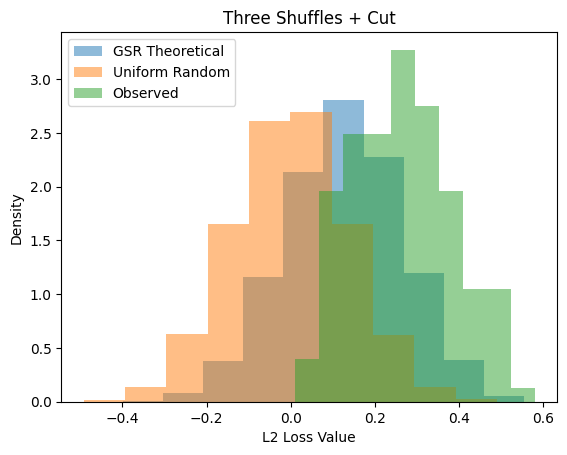

In [111]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(spearman_rank_corr)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Observed", alpha=0.5)
plt.xlabel('L2 Loss Value')
plt.ylabel('Density')
plt.title(f'Three Shuffles + Cut')
plt.legend(loc='best')
plt.savefig(f'Figures/Dealer{dealer_num}_L2_Hist.png')
plt.show()

In [110]:
min_length = min(len(GSR_single_shuffle_simulated_loss), len(uniform_random_single_shuffle_simulated_loss), len(empirical_single_shuffle_simulated_loss))

np.random.seed(42)  # For reproducibility
GSR_resampled = np.random.choice(GSR_single_shuffle_simulated_loss, min_length, replace=False)
uniform_random_resampled = np.random.choice(uniform_random_single_shuffle_simulated_loss, min_length, replace=False)
empirical_resampled = np.random.choice(empirical_single_shuffle_simulated_loss, min_length, replace=False)

data_anova = {
    'GSR': GSR_resampled,
    'Observed': empirical_resampled,
    'Uniform': uniform_random_resampled
}
df_anova = pd.DataFrame(data_anova)
df_anova_long = pd.melt(df_anova, var_name='Group', value_name='Loss')

anova_model_gsr_empirical = ols('Loss ~ C(Group)', data=df_anova_long).fit()
anova_table_gsr_empirical = sm.stats.anova_lm(anova_model_gsr_empirical, typ=2)

stargazer_gsr_empirical = Stargazer([anova_model_gsr_empirical])
stargazer_gsr_empirical.custom_columns([f"Dealer {dealer_num}: L2 ANOVA"], [1])
stargazer_gsr_empirical.show_model_numbers(False)
latex_str = stargazer_gsr_empirical.render_latex()

def latex2png(latex, filename, fontsize=500):
    """
    Render latex code to png image
    """
    return preview(latex,
                   viewer='file',
                   filename=filename,
                   euler=False,
                   dvioptions=['-D', f'{str(fontsize)}'])

latex2png(latex_str, f'Figures/Dealer{dealer_num}_L2_Anova.png')